In [1]:
import random
from pathlib import Path

from fastbook import *
from fastai.vision.augment import Resize, RandomResizedCrop
from fastai.vision.data import ImageBlock
from fastai.vision.learner import vision_learner
from fastcore.foundation import L
from torchvision.models.quantization import resnet18

In [2]:
from duckduckgo_search import DDGS

ddgs = DDGS()
def search_images(term, max_images=200): return L(ddgs.images(term, max_results=max_images)).itemgot('image')

In [3]:
import time
from fastai.vision.utils import download_images, resize_images

bear_types = ['grizzly','black','teddy']
path = Path('bears')

remove_old_data = False

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bear photo', max_images=150))
    resize_images(path/o, max_size=400, dest=path/o)
    time.sleep(10)

In [4]:
from fastai.data.transforms import get_image_files, RandomSplitter, parent_label
from fastai.vision.utils import verify_images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

In [5]:
from fastai.data.block import DataBlock, CategoryBlock

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

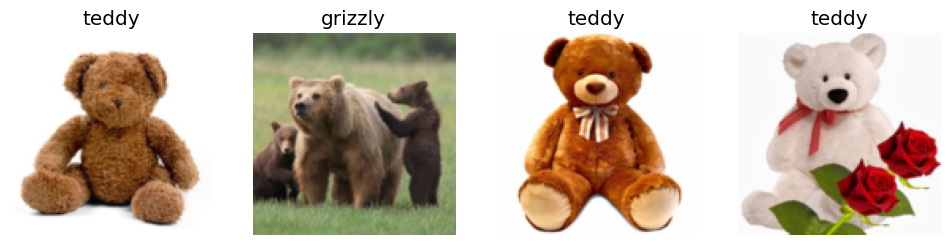

In [6]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# Data Augmetation

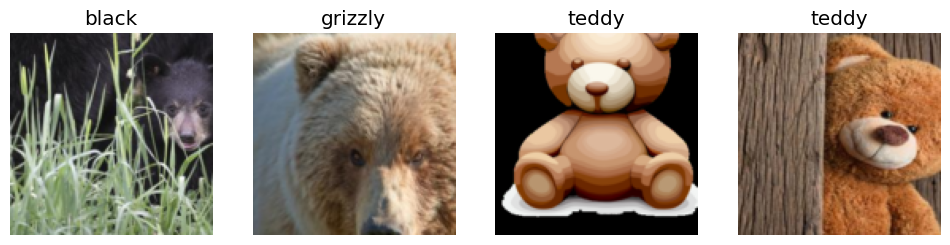

In [7]:
from fastai.vision.augment import RandomResizedCrop


bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

# Train Model for Cleaning Data

In [8]:
from fastai.metrics import error_rate

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/lukaswoodtli/Development/fastai-course/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukaswoodtli/Development/fastai-course/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.084139,0.210484,0.078212,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.188265,0.144913,0.033520,00:03
1,0.139278,0.141062,0.022346,00:02
2,0.114741,0.141861,0.027933,00:02
3,0.100849,0.141369,0.022346,00:02


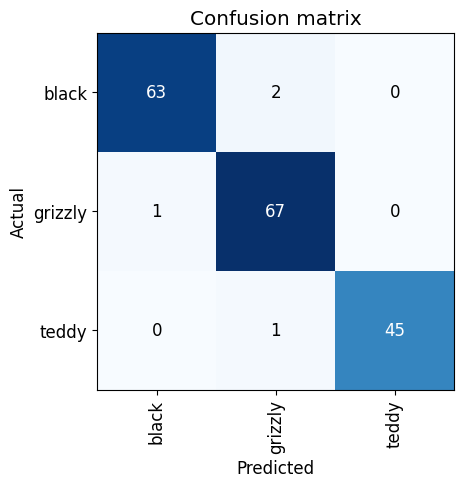

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

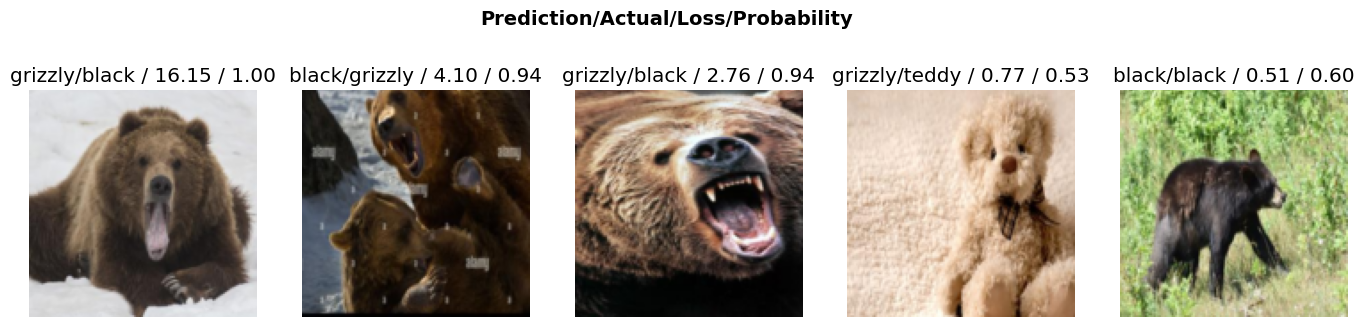

In [10]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [11]:
from fastai.vision.widgets import *
from fastai.vision.widgets import ImageClassifierCleaner
from utils import *

# might not work in PyCharm
cleaner = ImageClassifierCleaner(learn)
cleaner

In [12]:
# this needs to be done for each category separately
for idx in cleaner.delete():
    try: cleaner.fns[idx].unlink()
    except: pass
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [14]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.035192,0.166449,0.022346,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.016032,0.167136,0.022346,00:02
1,0.024030,0.170225,0.016760,00:02
2,0.024866,0.156468,0.016760,00:02
3,0.023062,0.175193,0.022346,00:02
4,0.024230,0.157979,0.022346,00:02
5,0.024267,0.172760,0.027933,00:02
6,0.025221,0.174224,0.022346,00:02
7,0.024344,0.178421,0.027933,00:02


In [15]:
# deploy the pkl file
learn.export('bears.pkl')

# Code for Inference (to be deployed)

In [66]:
#|default_exp app

In [67]:
#|export
from fastai.vision.all import *
import gradio as gr

In [68]:
#|export
learn = load_learner('bears.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'bears.pkl'

In [69]:
#|export
categories = ('grizzly','black','teddy')

def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))  # need to map tensor to float for gradio 

In [70]:
#|export

examples = ["black.jpg", "grizzly.jpg", "teddy.jpg"]

intf = gr.Interface(fn=classify_image, inputs="image", outputs="label", examples=examples)
intf.launch(inline=False)


Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


## export

In [71]:
import nbdev

nbdev.export.nb_export('02-data-augmentation-and-deployment.ipynb', '.')